In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_normalized_k5_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 276)
(772408, 8)
validation
(101248, 276)
(101248, 8)
test
(98888, 276)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 973704 (3.71 MB)


Trainable params: 973704 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:31 - loss: 2.6279 - STD: 0.1144 - MAE: 0.2236

 6/78 [=>............................] - ETA: 0s - loss: 1.7517 - STD: 0.1384 - MAE: 0.1811  

11/78 [===>..........................] - ETA: 0s - loss: 1.5913 - STD: 0.1912 - MAE: 0.1539

16/78 [=====>........................] - ETA: 0s - loss: 1.5196 - STD: 0.2022 - MAE: 0.1473

21/78 [=======>......................] - ETA: 0s - loss: 1.4772 - STD: 0.1951 - MAE: 0.1487

26/78 [=========>....................] - ETA: 0s - loss: 1.4505 - STD: 0.1907 - MAE: 0.1496

31/78 [==========>...................] - ETA: 0s - loss: 1.4299 - STD: 0.1918 - MAE: 0.1486

36/78 [============>.................] - ETA: 0s - loss: 1.4141 - STD: 0.1939 - MAE: 0.1472

41/78 [==============>...............] - ETA: 0s - loss: 1.4034 - STD: 0.1942 - MAE: 0.1468

46/78 [================>.............] - ETA: 0s - loss: 1.3936 - STD: 0.1931 - MAE: 0.1469

52/78 [===================>..........] - ETA: 0s - loss: 1.3853 - STD: 0.1924 - MAE: 0.1470

58/78 [=====================>........] - ETA: 0s - loss: 1.3788 - STD: 0.1926 - MAE: 0.1467

63/78 [=======================>......] - ETA: 0s - loss: 1.3731 - STD: 0.1926 - MAE: 0.1466

68/78 [=========================>....] - ETA: 0s - loss: 1.3693 - STD: 0.1924 - MAE: 0.1465

74/78 [===========================>..] - ETA: 0s - loss: 1.3652 - STD: 0.1923 - MAE: 0.1465

78/78 [==============================] - 3s 26ms/step - loss: 1.3629 - STD: 0.1923 - MAE: 0.1464 - val_loss: 1.2743 - val_STD: 0.1917 - val_MAE: 0.1449


Epoch 2/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3145 - STD: 0.1917 - MAE: 0.1451

 6/78 [=>............................] - ETA: 0s - loss: 1.3149 - STD: 0.1912 - MAE: 0.1454

11/78 [===>..........................] - ETA: 0s - loss: 1.3154 - STD: 0.1912 - MAE: 0.1455

16/78 [=====>........................] - ETA: 0s - loss: 1.3176 - STD: 0.1914 - MAE: 0.1455

21/78 [=======>......................] - ETA: 0s - loss: 1.3159 - STD: 0.1913 - MAE: 0.1455

26/78 [=========>....................] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1455

31/78 [==========>...................] - ETA: 0s - loss: 1.3156 - STD: 0.1915 - MAE: 0.1454

36/78 [============>.................] - ETA: 0s - loss: 1.3158 - STD: 0.1915 - MAE: 0.1454

41/78 [==============>...............] - ETA: 0s - loss: 1.3162 - STD: 0.1916 - MAE: 0.1454

46/78 [================>.............] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

51/78 [==================>...........] - ETA: 0s - loss: 1.3168 - STD: 0.1913 - MAE: 0.1455

56/78 [====================>.........] - ETA: 0s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

61/78 [======================>.......] - ETA: 0s - loss: 1.3173 - STD: 0.1913 - MAE: 0.1455

66/78 [========================>.....] - ETA: 0s - loss: 1.3174 - STD: 0.1913 - MAE: 0.1455

72/78 [==========================>...] - ETA: 0s - loss: 1.3170 - STD: 0.1913 - MAE: 0.1455

77/78 [============================>.] - ETA: 0s - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 1s 12ms/step - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2741 - val_STD: 0.1921 - val_MAE: 0.1448


Epoch 3/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3278 - STD: 0.1921 - MAE: 0.1460

 6/78 [=>............................] - ETA: 0s - loss: 1.3152 - STD: 0.1910 - MAE: 0.1455

12/78 [===>..........................] - ETA: 0s - loss: 1.3152 - STD: 0.1910 - MAE: 0.1457

17/78 [=====>........................] - ETA: 0s - loss: 1.3163 - STD: 0.1910 - MAE: 0.1457

22/78 [=======>......................] - ETA: 0s - loss: 1.3168 - STD: 0.1911 - MAE: 0.1457

27/78 [=========>....................] - ETA: 0s - loss: 1.3189 - STD: 0.1910 - MAE: 0.1458

32/78 [===========>..................] - ETA: 0s - loss: 1.3185 - STD: 0.1908 - MAE: 0.1459

38/78 [=============>................] - ETA: 0s - loss: 1.3179 - STD: 0.1909 - MAE: 0.1458

44/78 [===============>..............] - ETA: 0s - loss: 1.3176 - STD: 0.1912 - MAE: 0.1457

49/78 [=================>............] - ETA: 0s - loss: 1.3169 - STD: 0.1912 - MAE: 0.1456

55/78 [====================>.........] - ETA: 0s - loss: 1.3174 - STD: 0.1912 - MAE: 0.1456

60/78 [======================>.......] - ETA: 0s - loss: 1.3172 - STD: 0.1912 - MAE: 0.1456

65/78 [========================>.....] - ETA: 0s - loss: 1.3167 - STD: 0.1913 - MAE: 0.1456

70/78 [=========================>....] - ETA: 0s - loss: 1.3169 - STD: 0.1913 - MAE: 0.1455

75/78 [===========================>..] - ETA: 0s - loss: 1.3166 - STD: 0.1913 - MAE: 0.1455

78/78 [==============================] - 1s 11ms/step - loss: 1.3164 - STD: 0.1913 - MAE: 0.1455 - val_loss: 1.2734 - val_STD: 0.1942 - val_MAE: 0.1440


Epoch 4/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3229 - STD: 0.1942 - MAE: 0.1445

 6/78 [=>............................] - ETA: 0s - loss: 1.3254 - STD: 0.1923 - MAE: 0.1455

11/78 [===>..........................] - ETA: 0s - loss: 1.3188 - STD: 0.1907 - MAE: 0.1458

16/78 [=====>........................] - ETA: 0s - loss: 1.3193 - STD: 0.1915 - MAE: 0.1455

21/78 [=======>......................] - ETA: 0s - loss: 1.3189 - STD: 0.1914 - MAE: 0.1456

26/78 [=========>....................] - ETA: 0s - loss: 1.3188 - STD: 0.1912 - MAE: 0.1457

32/78 [===========>..................] - ETA: 0s - loss: 1.3192 - STD: 0.1912 - MAE: 0.1457

38/78 [=============>................] - ETA: 0s - loss: 1.3177 - STD: 0.1912 - MAE: 0.1456

44/78 [===============>..............] - ETA: 0s - loss: 1.3180 - STD: 0.1913 - MAE: 0.1456

49/78 [=================>............] - ETA: 0s - loss: 1.3183 - STD: 0.1912 - MAE: 0.1457

54/78 [===================>..........] - ETA: 0s - loss: 1.3174 - STD: 0.1913 - MAE: 0.1456

60/78 [======================>.......] - ETA: 0s - loss: 1.3176 - STD: 0.1913 - MAE: 0.1456

65/78 [========================>.....] - ETA: 0s - loss: 1.3174 - STD: 0.1912 - MAE: 0.1456

70/78 [=========================>....] - ETA: 0s - loss: 1.3169 - STD: 0.1914 - MAE: 0.1455

75/78 [===========================>..] - ETA: 0s - loss: 1.3166 - STD: 0.1915 - MAE: 0.1454

78/78 [==============================] - 1s 11ms/step - loss: 1.3164 - STD: 0.1915 - MAE: 0.1454 - val_loss: 1.2741 - val_STD: 0.1909 - val_MAE: 0.1453


Epoch 5/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3180 - STD: 0.1909 - MAE: 0.1460

 6/78 [=>............................] - ETA: 0s - loss: 1.3142 - STD: 0.1910 - MAE: 0.1455

11/78 [===>..........................] - ETA: 0s - loss: 1.3157 - STD: 0.1916 - MAE: 0.1453

16/78 [=====>........................] - ETA: 0s - loss: 1.3144 - STD: 0.1917 - MAE: 0.1452

21/78 [=======>......................] - ETA: 0s - loss: 1.3133 - STD: 0.1920 - MAE: 0.1450

27/78 [=========>....................] - ETA: 0s - loss: 1.3154 - STD: 0.1916 - MAE: 0.1453

32/78 [===========>..................] - ETA: 0s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1454

38/78 [=============>................] - ETA: 0s - loss: 1.3161 - STD: 0.1914 - MAE: 0.1454

43/78 [===============>..............] - ETA: 0s - loss: 1.3156 - STD: 0.1915 - MAE: 0.1453

48/78 [=================>............] - ETA: 0s - loss: 1.3151 - STD: 0.1916 - MAE: 0.1453

53/78 [===================>..........] - ETA: 0s - loss: 1.3156 - STD: 0.1915 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3151 - STD: 0.1914 - MAE: 0.1454

63/78 [=======================>......] - ETA: 0s - loss: 1.3147 - STD: 0.1914 - MAE: 0.1453

68/78 [=========================>....] - ETA: 0s - loss: 1.3143 - STD: 0.1915 - MAE: 0.1453

73/78 [===========================>..] - ETA: 0s - loss: 1.3138 - STD: 0.1915 - MAE: 0.1453

78/78 [==============================] - 1s 12ms/step - loss: 1.3131 - STD: 0.1915 - MAE: 0.1452 - val_loss: 1.2592 - val_STD: 0.1910 - val_MAE: 0.1445


Epoch 6/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2930 - STD: 0.1921 - MAE: 0.1438

 6/78 [=>............................] - ETA: 0s - loss: 1.2930 - STD: 0.1924 - MAE: 0.1439

11/78 [===>..........................] - ETA: 0s - loss: 1.2928 - STD: 0.1929 - MAE: 0.1436

16/78 [=====>........................] - ETA: 0s - loss: 1.2936 - STD: 0.1921 - MAE: 0.1440

22/78 [=======>......................] - ETA: 0s - loss: 1.2892 - STD: 0.1926 - MAE: 0.1436

27/78 [=========>....................] - ETA: 0s - loss: 1.2861 - STD: 0.1924 - MAE: 0.1437

33/78 [===========>..................] - ETA: 0s - loss: 1.2832 - STD: 0.1925 - MAE: 0.1435

38/78 [=============>................] - ETA: 0s - loss: 1.2796 - STD: 0.1927 - MAE: 0.1434

43/78 [===============>..............] - ETA: 0s - loss: 1.2751 - STD: 0.1932 - MAE: 0.1431

48/78 [=================>............] - ETA: 0s - loss: 1.2703 - STD: 0.1935 - MAE: 0.1429

53/78 [===================>..........] - ETA: 0s - loss: 1.2656 - STD: 0.1941 - MAE: 0.1425

58/78 [=====================>........] - ETA: 0s - loss: 1.2614 - STD: 0.1944 - MAE: 0.1423

63/78 [=======================>......] - ETA: 0s - loss: 1.2577 - STD: 0.1948 - MAE: 0.1420

68/78 [=========================>....] - ETA: 0s - loss: 1.2553 - STD: 0.1951 - MAE: 0.1419

73/78 [===========================>..] - ETA: 0s - loss: 1.2522 - STD: 0.1952 - MAE: 0.1418

78/78 [==============================] - 1s 12ms/step - loss: 1.2496 - STD: 0.1955 - MAE: 0.1416 - val_loss: 1.1627 - val_STD: 0.1922 - val_MAE: 0.1420


Epoch 7/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1984 - STD: 0.1922 - MAE: 0.1414

 7/78 [=>............................] - ETA: 0s - loss: 1.2090 - STD: 0.1990 - MAE: 0.1393

13/78 [====>.........................] - ETA: 0s - loss: 1.2040 - STD: 0.1984 - MAE: 0.1394

18/78 [=====>........................] - ETA: 0s - loss: 1.2003 - STD: 0.1985 - MAE: 0.1393

24/78 [========>.....................] - ETA: 0s - loss: 1.1978 - STD: 0.1990 - MAE: 0.1389

29/78 [==========>...................] - ETA: 0s - loss: 1.1965 - STD: 0.1993 - MAE: 0.1388

34/78 [============>.................] - ETA: 0s - loss: 1.1957 - STD: 0.1991 - MAE: 0.1388

39/78 [==============>...............] - ETA: 0s - loss: 1.1943 - STD: 0.1992 - MAE: 0.1387

44/78 [===============>..............] - ETA: 0s - loss: 1.1923 - STD: 0.1998 - MAE: 0.1384

50/78 [==================>...........] - ETA: 0s - loss: 1.1905 - STD: 0.1998 - MAE: 0.1383

55/78 [====================>.........] - ETA: 0s - loss: 1.1894 - STD: 0.1999 - MAE: 0.1382

60/78 [======================>.......] - ETA: 0s - loss: 1.1875 - STD: 0.2002 - MAE: 0.1380

65/78 [========================>.....] - ETA: 0s - loss: 1.1867 - STD: 0.2003 - MAE: 0.1379

70/78 [=========================>....] - ETA: 0s - loss: 1.1849 - STD: 0.2005 - MAE: 0.1378

76/78 [============================>.] - ETA: 0s - loss: 1.1832 - STD: 0.2007 - MAE: 0.1376

78/78 [==============================] - 1s 11ms/step - loss: 1.1824 - STD: 0.2007 - MAE: 0.1376 - val_loss: 1.1306 - val_STD: 0.2058 - val_MAE: 0.1351


Epoch 8/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1744 - STD: 0.2044 - MAE: 0.1358

 6/78 [=>............................] - ETA: 0s - loss: 1.1614 - STD: 0.2040 - MAE: 0.1354

11/78 [===>..........................] - ETA: 0s - loss: 1.1567 - STD: 0.2044 - MAE: 0.1350

17/78 [=====>........................] - ETA: 0s - loss: 1.1588 - STD: 0.2038 - MAE: 0.1353

23/78 [=======>......................] - ETA: 0s - loss: 1.1576 - STD: 0.2036 - MAE: 0.1354

29/78 [==========>...................] - ETA: 0s - loss: 1.1582 - STD: 0.2037 - MAE: 0.1354

34/78 [============>.................] - ETA: 0s - loss: 1.1585 - STD: 0.2036 - MAE: 0.1354

39/78 [==============>...............] - ETA: 0s - loss: 1.1577 - STD: 0.2039 - MAE: 0.1353

45/78 [================>.............] - ETA: 0s - loss: 1.1571 - STD: 0.2038 - MAE: 0.1353

50/78 [==================>...........] - ETA: 0s - loss: 1.1563 - STD: 0.2039 - MAE: 0.1352

55/78 [====================>.........] - ETA: 0s - loss: 1.1562 - STD: 0.2039 - MAE: 0.1352

60/78 [======================>.......] - ETA: 0s - loss: 1.1562 - STD: 0.2038 - MAE: 0.1352

65/78 [========================>.....] - ETA: 0s - loss: 1.1559 - STD: 0.2038 - MAE: 0.1352

70/78 [=========================>....] - ETA: 0s - loss: 1.1560 - STD: 0.2038 - MAE: 0.1352

75/78 [===========================>..] - ETA: 0s - loss: 1.1555 - STD: 0.2039 - MAE: 0.1352

78/78 [==============================] - 1s 11ms/step - loss: 1.1553 - STD: 0.2038 - MAE: 0.1352 - val_loss: 1.1236 - val_STD: 0.2049 - val_MAE: 0.1351


Epoch 9/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1398 - STD: 0.2042 - MAE: 0.1340

 6/78 [=>............................] - ETA: 0s - loss: 1.1451 - STD: 0.2052 - MAE: 0.1341

11/78 [===>..........................] - ETA: 0s - loss: 1.1483 - STD: 0.2051 - MAE: 0.1343

17/78 [=====>........................] - ETA: 0s - loss: 1.1464 - STD: 0.2052 - MAE: 0.1342

22/78 [=======>......................] - ETA: 0s - loss: 1.1446 - STD: 0.2056 - MAE: 0.1339

27/78 [=========>....................] - ETA: 0s - loss: 1.1458 - STD: 0.2054 - MAE: 0.1341

32/78 [===========>..................] - ETA: 0s - loss: 1.1448 - STD: 0.2053 - MAE: 0.1341

37/78 [=============>................] - ETA: 0s - loss: 1.1445 - STD: 0.2054 - MAE: 0.1341

42/78 [===============>..............] - ETA: 0s - loss: 1.1429 - STD: 0.2054 - MAE: 0.1340

47/78 [=================>............] - ETA: 0s - loss: 1.1423 - STD: 0.2053 - MAE: 0.1340

52/78 [===================>..........] - ETA: 0s - loss: 1.1426 - STD: 0.2053 - MAE: 0.1340

58/78 [=====================>........] - ETA: 0s - loss: 1.1421 - STD: 0.2053 - MAE: 0.1340

63/78 [=======================>......] - ETA: 0s - loss: 1.1413 - STD: 0.2054 - MAE: 0.1339

68/78 [=========================>....] - ETA: 0s - loss: 1.1404 - STD: 0.2055 - MAE: 0.1338

73/78 [===========================>..] - ETA: 0s - loss: 1.1399 - STD: 0.2055 - MAE: 0.1337

78/78 [==============================] - ETA: 0s - loss: 1.1389 - STD: 0.2056 - MAE: 0.1337

78/78 [==============================] - 1s 12ms/step - loss: 1.1389 - STD: 0.2056 - MAE: 0.1337 - val_loss: 1.1110 - val_STD: 0.2098 - val_MAE: 0.1323


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1237 - STD: 0.2090 - MAE: 0.1316

 6/78 [=>............................] - ETA: 0s - loss: 1.1178 - STD: 0.2078 - MAE: 0.1318

11/78 [===>..........................] - ETA: 0s - loss: 1.1193 - STD: 0.2084 - MAE: 0.1315

16/78 [=====>........................] - ETA: 0s - loss: 1.1137 - STD: 0.2087 - MAE: 0.1310

21/78 [=======>......................] - ETA: 0s - loss: 1.1190 - STD: 0.2082 - MAE: 0.1315

27/78 [=========>....................] - ETA: 0s - loss: 1.1216 - STD: 0.2078 - MAE: 0.1319

32/78 [===========>..................] - ETA: 0s - loss: 1.1222 - STD: 0.2080 - MAE: 0.1318

37/78 [=============>................] - ETA: 0s - loss: 1.1228 - STD: 0.2080 - MAE: 0.1318

42/78 [===============>..............] - ETA: 0s - loss: 1.1234 - STD: 0.2080 - MAE: 0.1319

47/78 [=================>............] - ETA: 0s - loss: 1.1229 - STD: 0.2081 - MAE: 0.1318

52/78 [===================>..........] - ETA: 0s - loss: 1.1221 - STD: 0.2081 - MAE: 0.1318

57/78 [====================>.........] - ETA: 0s - loss: 1.1215 - STD: 0.2081 - MAE: 0.1318

62/78 [======================>.......] - ETA: 0s - loss: 1.1213 - STD: 0.2081 - MAE: 0.1318

67/78 [========================>.....] - ETA: 0s - loss: 1.1207 - STD: 0.2081 - MAE: 0.1318

73/78 [===========================>..] - ETA: 0s - loss: 1.1206 - STD: 0.2083 - MAE: 0.1317

78/78 [==============================] - 1s 11ms/step - loss: 1.1207 - STD: 0.2082 - MAE: 0.1317 - val_loss: 1.1010 - val_STD: 0.2058 - val_MAE: 0.1336


Epoch 11/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0995 - STD: 0.2054 - MAE: 0.1318

 6/78 [=>............................] - ETA: 0s - loss: 1.1141 - STD: 0.2092 - MAE: 0.1310

11/78 [===>..........................] - ETA: 0s - loss: 1.1128 - STD: 0.2091 - MAE: 0.1310

16/78 [=====>........................] - ETA: 0s - loss: 1.1139 - STD: 0.2096 - MAE: 0.1309

21/78 [=======>......................] - ETA: 0s - loss: 1.1156 - STD: 0.2093 - MAE: 0.1311

27/78 [=========>....................] - ETA: 0s - loss: 1.1143 - STD: 0.2091 - MAE: 0.1311

32/78 [===========>..................] - ETA: 0s - loss: 1.1142 - STD: 0.2089 - MAE: 0.1312

38/78 [=============>................] - ETA: 0s - loss: 1.1134 - STD: 0.2091 - MAE: 0.1311

43/78 [===============>..............] - ETA: 0s - loss: 1.1133 - STD: 0.2091 - MAE: 0.1311

48/78 [=================>............] - ETA: 0s - loss: 1.1121 - STD: 0.2092 - MAE: 0.1310

53/78 [===================>..........] - ETA: 0s - loss: 1.1114 - STD: 0.2093 - MAE: 0.1310

59/78 [=====================>........] - ETA: 0s - loss: 1.1114 - STD: 0.2093 - MAE: 0.1310

64/78 [=======================>......] - ETA: 0s - loss: 1.1116 - STD: 0.2092 - MAE: 0.1310

69/78 [=========================>....] - ETA: 0s - loss: 1.1113 - STD: 0.2093 - MAE: 0.1309

74/78 [===========================>..] - ETA: 0s - loss: 1.1115 - STD: 0.2093 - MAE: 0.1310

78/78 [==============================] - 1s 12ms/step - loss: 1.1112 - STD: 0.2093 - MAE: 0.1309 - val_loss: 1.0993 - val_STD: 0.2169 - val_MAE: 0.1289


Epoch 12/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1105 - STD: 0.2155 - MAE: 0.1284

 6/78 [=>............................] - ETA: 0s - loss: 1.1065 - STD: 0.2099 - MAE: 0.1304

11/78 [===>..........................] - ETA: 0s - loss: 1.1032 - STD: 0.2103 - MAE: 0.1301

16/78 [=====>........................] - ETA: 0s - loss: 1.1014 - STD: 0.2104 - MAE: 0.1299

22/78 [=======>......................] - ETA: 0s - loss: 1.1030 - STD: 0.2101 - MAE: 0.1303

27/78 [=========>....................] - ETA: 0s - loss: 1.1052 - STD: 0.2099 - MAE: 0.1304

32/78 [===========>..................] - ETA: 0s - loss: 1.1050 - STD: 0.2098 - MAE: 0.1305

37/78 [=============>................] - ETA: 0s - loss: 1.1055 - STD: 0.2100 - MAE: 0.1304

42/78 [===============>..............] - ETA: 0s - loss: 1.1077 - STD: 0.2095 - MAE: 0.1307

47/78 [=================>............] - ETA: 0s - loss: 1.1081 - STD: 0.2096 - MAE: 0.1307

52/78 [===================>..........] - ETA: 0s - loss: 1.1080 - STD: 0.2098 - MAE: 0.1306

57/78 [====================>.........] - ETA: 0s - loss: 1.1071 - STD: 0.2097 - MAE: 0.1306

62/78 [======================>.......] - ETA: 0s - loss: 1.1070 - STD: 0.2097 - MAE: 0.1306

67/78 [========================>.....] - ETA: 0s - loss: 1.1069 - STD: 0.2097 - MAE: 0.1306

72/78 [==========================>...] - ETA: 0s - loss: 1.1072 - STD: 0.2097 - MAE: 0.1306

78/78 [==============================] - ETA: 0s - loss: 1.1062 - STD: 0.2097 - MAE: 0.1306

78/78 [==============================] - 1s 12ms/step - loss: 1.1062 - STD: 0.2097 - MAE: 0.1306 - val_loss: 1.0955 - val_STD: 0.2159 - val_MAE: 0.1293


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1167 - STD: 0.2140 - MAE: 0.1292

 6/78 [=>............................] - ETA: 0s - loss: 1.0991 - STD: 0.2110 - MAE: 0.1296

11/78 [===>..........................] - ETA: 0s - loss: 1.1013 - STD: 0.2108 - MAE: 0.1299

16/78 [=====>........................] - ETA: 0s - loss: 1.0986 - STD: 0.2107 - MAE: 0.1298

21/78 [=======>......................] - ETA: 0s - loss: 1.0996 - STD: 0.2105 - MAE: 0.1300

26/78 [=========>....................] - ETA: 0s - loss: 1.0993 - STD: 0.2102 - MAE: 0.1301

31/78 [==========>...................] - ETA: 0s - loss: 1.0997 - STD: 0.2102 - MAE: 0.1301

36/78 [============>.................] - ETA: 0s - loss: 1.0998 - STD: 0.2105 - MAE: 0.1300

41/78 [==============>...............] - ETA: 0s - loss: 1.0994 - STD: 0.2106 - MAE: 0.1299

47/78 [=================>............] - ETA: 0s - loss: 1.0998 - STD: 0.2106 - MAE: 0.1299

52/78 [===================>..........] - ETA: 0s - loss: 1.0999 - STD: 0.2104 - MAE: 0.1300

57/78 [====================>.........] - ETA: 0s - loss: 1.1007 - STD: 0.2104 - MAE: 0.1301

62/78 [======================>.......] - ETA: 0s - loss: 1.1004 - STD: 0.2104 - MAE: 0.1300

67/78 [========================>.....] - ETA: 0s - loss: 1.1004 - STD: 0.2104 - MAE: 0.1301

72/78 [==========================>...] - ETA: 0s - loss: 1.1005 - STD: 0.2103 - MAE: 0.1301

77/78 [============================>.] - ETA: 0s - loss: 1.1003 - STD: 0.2103 - MAE: 0.1301

78/78 [==============================] - 1s 12ms/step - loss: 1.1003 - STD: 0.2103 - MAE: 0.1301 - val_loss: 1.0943 - val_STD: 0.2100 - val_MAE: 0.1316


Epoch 14/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1029 - STD: 0.2081 - MAE: 0.1314

 6/78 [=>............................] - ETA: 0s - loss: 1.0977 - STD: 0.2102 - MAE: 0.1301

11/78 [===>..........................] - ETA: 0s - loss: 1.0981 - STD: 0.2103 - MAE: 0.1300

16/78 [=====>........................] - ETA: 0s - loss: 1.0983 - STD: 0.2101 - MAE: 0.1301

22/78 [=======>......................] - ETA: 0s - loss: 1.0988 - STD: 0.2105 - MAE: 0.1299

27/78 [=========>....................] - ETA: 0s - loss: 1.0983 - STD: 0.2105 - MAE: 0.1299

32/78 [===========>..................] - ETA: 0s - loss: 1.0985 - STD: 0.2106 - MAE: 0.1299

37/78 [=============>................] - ETA: 0s - loss: 1.0987 - STD: 0.2104 - MAE: 0.1300

43/78 [===============>..............] - ETA: 0s - loss: 1.0990 - STD: 0.2105 - MAE: 0.1300

48/78 [=================>............] - ETA: 0s - loss: 1.0985 - STD: 0.2105 - MAE: 0.1300

54/78 [===================>..........] - ETA: 0s - loss: 1.0981 - STD: 0.2104 - MAE: 0.1300

59/78 [=====================>........] - ETA: 0s - loss: 1.0975 - STD: 0.2105 - MAE: 0.1299

65/78 [========================>.....] - ETA: 0s - loss: 1.0967 - STD: 0.2106 - MAE: 0.1298

70/78 [=========================>....] - ETA: 0s - loss: 1.0962 - STD: 0.2107 - MAE: 0.1298

76/78 [============================>.] - ETA: 0s - loss: 1.0963 - STD: 0.2107 - MAE: 0.1297

78/78 [==============================] - 1s 11ms/step - loss: 1.0963 - STD: 0.2106 - MAE: 0.1298 - val_loss: 1.0947 - val_STD: 0.2124 - val_MAE: 0.1305


Epoch 15/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1156 - STD: 0.2115 - MAE: 0.1307

 6/78 [=>............................] - ETA: 0s - loss: 1.0957 - STD: 0.2122 - MAE: 0.1291

11/78 [===>..........................] - ETA: 0s - loss: 1.0943 - STD: 0.2110 - MAE: 0.1296

16/78 [=====>........................] - ETA: 0s - loss: 1.0934 - STD: 0.2109 - MAE: 0.1296

21/78 [=======>......................] - ETA: 0s - loss: 1.0943 - STD: 0.2108 - MAE: 0.1297

27/78 [=========>....................] - ETA: 0s - loss: 1.0947 - STD: 0.2108 - MAE: 0.1297

32/78 [===========>..................] - ETA: 0s - loss: 1.0951 - STD: 0.2107 - MAE: 0.1298

37/78 [=============>................] - ETA: 0s - loss: 1.0952 - STD: 0.2107 - MAE: 0.1298

42/78 [===============>..............] - ETA: 0s - loss: 1.0940 - STD: 0.2109 - MAE: 0.1296

47/78 [=================>............] - ETA: 0s - loss: 1.0940 - STD: 0.2109 - MAE: 0.1296

52/78 [===================>..........] - ETA: 0s - loss: 1.0939 - STD: 0.2110 - MAE: 0.1296

57/78 [====================>.........] - ETA: 0s - loss: 1.0932 - STD: 0.2110 - MAE: 0.1296

62/78 [======================>.......] - ETA: 0s - loss: 1.0927 - STD: 0.2108 - MAE: 0.1296

67/78 [========================>.....] - ETA: 0s - loss: 1.0927 - STD: 0.2109 - MAE: 0.1295

72/78 [==========================>...] - ETA: 0s - loss: 1.0924 - STD: 0.2109 - MAE: 0.1295

78/78 [==============================] - ETA: 0s - loss: 1.0922 - STD: 0.2110 - MAE: 0.1295

78/78 [==============================] - 1s 11ms/step - loss: 1.0922 - STD: 0.2110 - MAE: 0.1295 - val_loss: 1.0971 - val_STD: 0.2156 - val_MAE: 0.1294


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0863 - STD: 0.2148 - MAE: 0.1275

 6/78 [=>............................] - ETA: 0s - loss: 1.0899 - STD: 0.2112 - MAE: 0.1293

11/78 [===>..........................] - ETA: 0s - loss: 1.0891 - STD: 0.2116 - MAE: 0.1291

16/78 [=====>........................] - ETA: 0s - loss: 1.0902 - STD: 0.2116 - MAE: 0.1292

21/78 [=======>......................] - ETA: 0s - loss: 1.0900 - STD: 0.2113 - MAE: 0.1292

26/78 [=========>....................] - ETA: 0s - loss: 1.0887 - STD: 0.2112 - MAE: 0.1292

31/78 [==========>...................] - ETA: 0s - loss: 1.0886 - STD: 0.2111 - MAE: 0.1293

37/78 [=============>................] - ETA: 0s - loss: 1.0888 - STD: 0.2114 - MAE: 0.1291

42/78 [===============>..............] - ETA: 0s - loss: 1.0882 - STD: 0.2115 - MAE: 0.1291

47/78 [=================>............] - ETA: 0s - loss: 1.0889 - STD: 0.2113 - MAE: 0.1292

53/78 [===================>..........] - ETA: 0s - loss: 1.0885 - STD: 0.2114 - MAE: 0.1291

58/78 [=====================>........] - ETA: 0s - loss: 1.0887 - STD: 0.2113 - MAE: 0.1292

63/78 [=======================>......] - ETA: 0s - loss: 1.0875 - STD: 0.2113 - MAE: 0.1291

68/78 [=========================>....] - ETA: 0s - loss: 1.0877 - STD: 0.2113 - MAE: 0.1292

73/78 [===========================>..] - ETA: 0s - loss: 1.0875 - STD: 0.2113 - MAE: 0.1291

78/78 [==============================] - 1s 11ms/step - loss: 1.0877 - STD: 0.2114 - MAE: 0.1291 - val_loss: 1.0993 - val_STD: 0.2127 - val_MAE: 0.1305


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0894 - STD: 0.2134 - MAE: 0.1284

 6/78 [=>............................] - ETA: 0s - loss: 1.0909 - STD: 0.2102 - MAE: 0.1298

11/78 [===>..........................] - ETA: 0s - loss: 1.0878 - STD: 0.2109 - MAE: 0.1293

16/78 [=====>........................] - ETA: 0s - loss: 1.0881 - STD: 0.2110 - MAE: 0.1293

21/78 [=======>......................] - ETA: 0s - loss: 1.0858 - STD: 0.2114 - MAE: 0.1290

26/78 [=========>....................] - ETA: 0s - loss: 1.0861 - STD: 0.2117 - MAE: 0.1289

31/78 [==========>...................] - ETA: 0s - loss: 1.0849 - STD: 0.2117 - MAE: 0.1288

36/78 [============>.................] - ETA: 0s - loss: 1.0846 - STD: 0.2118 - MAE: 0.1288

41/78 [==============>...............] - ETA: 0s - loss: 1.0847 - STD: 0.2117 - MAE: 0.1288

46/78 [================>.............] - ETA: 0s - loss: 1.0834 - STD: 0.2118 - MAE: 0.1288

51/78 [==================>...........] - ETA: 0s - loss: 1.0830 - STD: 0.2117 - MAE: 0.1288

56/78 [====================>.........] - ETA: 0s - loss: 1.0826 - STD: 0.2117 - MAE: 0.1288

61/78 [======================>.......] - ETA: 0s - loss: 1.0827 - STD: 0.2118 - MAE: 0.1288

66/78 [========================>.....] - ETA: 0s - loss: 1.0831 - STD: 0.2118 - MAE: 0.1288

71/78 [==========================>...] - ETA: 0s - loss: 1.0833 - STD: 0.2118 - MAE: 0.1288

77/78 [============================>.] - ETA: 0s - loss: 1.0837 - STD: 0.2117 - MAE: 0.1289

78/78 [==============================] - 1s 12ms/step - loss: 1.0837 - STD: 0.2116 - MAE: 0.1289 - val_loss: 1.0922 - val_STD: 0.2160 - val_MAE: 0.1290


Epoch 18/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0703 - STD: 0.2172 - MAE: 0.1263

 7/78 [=>............................] - ETA: 0s - loss: 1.0835 - STD: 0.2131 - MAE: 0.1285

12/78 [===>..........................] - ETA: 0s - loss: 1.0814 - STD: 0.2125 - MAE: 0.1286

17/78 [=====>........................] - ETA: 0s - loss: 1.0811 - STD: 0.2124 - MAE: 0.1285

22/78 [=======>......................] - ETA: 0s - loss: 1.0836 - STD: 0.2118 - MAE: 0.1289

27/78 [=========>....................] - ETA: 0s - loss: 1.0828 - STD: 0.2119 - MAE: 0.1288

32/78 [===========>..................] - ETA: 0s - loss: 1.0830 - STD: 0.2118 - MAE: 0.1289

37/78 [=============>................] - ETA: 0s - loss: 1.0825 - STD: 0.2118 - MAE: 0.1289

42/78 [===============>..............] - ETA: 0s - loss: 1.0821 - STD: 0.2118 - MAE: 0.1288

47/78 [=================>............] - ETA: 0s - loss: 1.0815 - STD: 0.2121 - MAE: 0.1287

52/78 [===================>..........] - ETA: 0s - loss: 1.0808 - STD: 0.2121 - MAE: 0.1286

57/78 [====================>.........] - ETA: 0s - loss: 1.0799 - STD: 0.2120 - MAE: 0.1286

62/78 [======================>.......] - ETA: 0s - loss: 1.0796 - STD: 0.2120 - MAE: 0.1286

67/78 [========================>.....] - ETA: 0s - loss: 1.0794 - STD: 0.2121 - MAE: 0.1286

72/78 [==========================>...] - ETA: 0s - loss: 1.0791 - STD: 0.2121 - MAE: 0.1286

77/78 [============================>.] - ETA: 0s - loss: 1.0783 - STD: 0.2122 - MAE: 0.1285

78/78 [==============================] - 1s 11ms/step - loss: 1.0781 - STD: 0.2123 - MAE: 0.1284 - val_loss: 1.0995 - val_STD: 0.2061 - val_MAE: 0.1333


Epoch 19/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0643 - STD: 0.2086 - MAE: 0.1296

 6/78 [=>............................] - ETA: 0s - loss: 1.0734 - STD: 0.2117 - MAE: 0.1285

11/78 [===>..........................] - ETA: 0s - loss: 1.0737 - STD: 0.2122 - MAE: 0.1284

16/78 [=====>........................] - ETA: 0s - loss: 1.0739 - STD: 0.2125 - MAE: 0.1282

21/78 [=======>......................] - ETA: 0s - loss: 1.0722 - STD: 0.2128 - MAE: 0.1280

26/78 [=========>....................] - ETA: 0s - loss: 1.0729 - STD: 0.2129 - MAE: 0.1280

31/78 [==========>...................] - ETA: 0s - loss: 1.0732 - STD: 0.2125 - MAE: 0.1281

37/78 [=============>................] - ETA: 0s - loss: 1.0742 - STD: 0.2125 - MAE: 0.1282

42/78 [===============>..............] - ETA: 0s - loss: 1.0749 - STD: 0.2125 - MAE: 0.1282

47/78 [=================>............] - ETA: 0s - loss: 1.0741 - STD: 0.2127 - MAE: 0.1281

52/78 [===================>..........] - ETA: 0s - loss: 1.0744 - STD: 0.2127 - MAE: 0.1281

57/78 [====================>.........] - ETA: 0s - loss: 1.0740 - STD: 0.2128 - MAE: 0.1281

62/78 [======================>.......] - ETA: 0s - loss: 1.0738 - STD: 0.2127 - MAE: 0.1281

67/78 [========================>.....] - ETA: 0s - loss: 1.0735 - STD: 0.2126 - MAE: 0.1281

72/78 [==========================>...] - ETA: 0s - loss: 1.0736 - STD: 0.2126 - MAE: 0.1281

77/78 [============================>.] - ETA: 0s - loss: 1.0733 - STD: 0.2125 - MAE: 0.1281

78/78 [==============================] - 1s 12ms/step - loss: 1.0733 - STD: 0.2125 - MAE: 0.1282 - val_loss: 1.0956 - val_STD: 0.2173 - val_MAE: 0.1285


Epoch 20/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0524 - STD: 0.2187 - MAE: 0.1245

 6/78 [=>............................] - ETA: 0s - loss: 1.0743 - STD: 0.2139 - MAE: 0.1276

11/78 [===>..........................] - ETA: 0s - loss: 1.0708 - STD: 0.2140 - MAE: 0.1274

16/78 [=====>........................] - ETA: 0s - loss: 1.0684 - STD: 0.2137 - MAE: 0.1274

21/78 [=======>......................] - ETA: 0s - loss: 1.0709 - STD: 0.2129 - MAE: 0.1280

27/78 [=========>....................] - ETA: 0s - loss: 1.0701 - STD: 0.2130 - MAE: 0.1279

32/78 [===========>..................] - ETA: 0s - loss: 1.0700 - STD: 0.2131 - MAE: 0.1278

37/78 [=============>................] - ETA: 0s - loss: 1.0688 - STD: 0.2132 - MAE: 0.1277

42/78 [===============>..............] - ETA: 0s - loss: 1.0694 - STD: 0.2133 - MAE: 0.1277

47/78 [=================>............] - ETA: 0s - loss: 1.0693 - STD: 0.2133 - MAE: 0.1277

52/78 [===================>..........] - ETA: 0s - loss: 1.0692 - STD: 0.2132 - MAE: 0.1277

57/78 [====================>.........] - ETA: 0s - loss: 1.0697 - STD: 0.2131 - MAE: 0.1278

62/78 [======================>.......] - ETA: 0s - loss: 1.0694 - STD: 0.2130 - MAE: 0.1278

67/78 [========================>.....] - ETA: 0s - loss: 1.0688 - STD: 0.2131 - MAE: 0.1278

72/78 [==========================>...] - ETA: 0s - loss: 1.0686 - STD: 0.2131 - MAE: 0.1277

77/78 [============================>.] - ETA: 0s - loss: 1.0687 - STD: 0.2131 - MAE: 0.1278

78/78 [==============================] - 1s 11ms/step - loss: 1.0684 - STD: 0.2131 - MAE: 0.1277 - val_loss: 1.0972 - val_STD: 0.2118 - val_MAE: 0.1307


Epoch 21/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0539 - STD: 0.2148 - MAE: 0.1267

 6/78 [=>............................] - ETA: 0s - loss: 1.0627 - STD: 0.2138 - MAE: 0.1273

11/78 [===>..........................] - ETA: 0s - loss: 1.0669 - STD: 0.2128 - MAE: 0.1279

16/78 [=====>........................] - ETA: 0s - loss: 1.0647 - STD: 0.2128 - MAE: 0.1278

21/78 [=======>......................] - ETA: 0s - loss: 1.0637 - STD: 0.2131 - MAE: 0.1276

26/78 [=========>....................] - ETA: 0s - loss: 1.0640 - STD: 0.2134 - MAE: 0.1275

32/78 [===========>..................] - ETA: 0s - loss: 1.0637 - STD: 0.2136 - MAE: 0.1273

37/78 [=============>................] - ETA: 0s - loss: 1.0644 - STD: 0.2134 - MAE: 0.1275

42/78 [===============>..............] - ETA: 0s - loss: 1.0648 - STD: 0.2133 - MAE: 0.1275

47/78 [=================>............] - ETA: 0s - loss: 1.0646 - STD: 0.2132 - MAE: 0.1275

52/78 [===================>..........] - ETA: 0s - loss: 1.0634 - STD: 0.2134 - MAE: 0.1274

57/78 [====================>.........] - ETA: 0s - loss: 1.0634 - STD: 0.2134 - MAE: 0.1274

62/78 [======================>.......] - ETA: 0s - loss: 1.0636 - STD: 0.2134 - MAE: 0.1274

67/78 [========================>.....] - ETA: 0s - loss: 1.0634 - STD: 0.2135 - MAE: 0.1273

72/78 [==========================>...] - ETA: 0s - loss: 1.0639 - STD: 0.2135 - MAE: 0.1273

77/78 [============================>.] - ETA: 0s - loss: 1.0639 - STD: 0.2135 - MAE: 0.1274

78/78 [==============================] - 1s 11ms/step - loss: 1.0639 - STD: 0.2134 - MAE: 0.1274 - val_loss: 1.1070 - val_STD: 0.2026 - val_MAE: 0.1349


Epoch 22/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0632 - STD: 0.2070 - MAE: 0.1299

 6/78 [=>............................] - ETA: 0s - loss: 1.0569 - STD: 0.2135 - MAE: 0.1271

11/78 [===>..........................] - ETA: 0s - loss: 1.0616 - STD: 0.2136 - MAE: 0.1273

16/78 [=====>........................] - ETA: 0s - loss: 1.0620 - STD: 0.2136 - MAE: 0.1273

21/78 [=======>......................] - ETA: 0s - loss: 1.0601 - STD: 0.2135 - MAE: 0.1273

26/78 [=========>....................] - ETA: 0s - loss: 1.0598 - STD: 0.2136 - MAE: 0.1272

32/78 [===========>..................] - ETA: 0s - loss: 1.0595 - STD: 0.2138 - MAE: 0.1272

37/78 [=============>................] - ETA: 0s - loss: 1.0594 - STD: 0.2139 - MAE: 0.1271

42/78 [===============>..............] - ETA: 0s - loss: 1.0603 - STD: 0.2137 - MAE: 0.1272

47/78 [=================>............] - ETA: 0s - loss: 1.0603 - STD: 0.2136 - MAE: 0.1272

52/78 [===================>..........] - ETA: 0s - loss: 1.0602 - STD: 0.2137 - MAE: 0.1272

57/78 [====================>.........] - ETA: 0s - loss: 1.0603 - STD: 0.2138 - MAE: 0.1272

62/78 [======================>.......] - ETA: 0s - loss: 1.0603 - STD: 0.2137 - MAE: 0.1272

67/78 [========================>.....] - ETA: 0s - loss: 1.0595 - STD: 0.2137 - MAE: 0.1272

72/78 [==========================>...] - ETA: 0s - loss: 1.0594 - STD: 0.2137 - MAE: 0.1272

78/78 [==============================] - ETA: 0s - loss: 1.0591 - STD: 0.2137 - MAE: 0.1271

78/78 [==============================] - 1s 11ms/step - loss: 1.0591 - STD: 0.2137 - MAE: 0.1271 - val_loss: 1.1096 - val_STD: 0.2097 - val_MAE: 0.1319


Epoch 23/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0716 - STD: 0.2129 - MAE: 0.1284

 6/78 [=>............................] - ETA: 0s - loss: 1.0614 - STD: 0.2138 - MAE: 0.1274

11/78 [===>..........................] - ETA: 0s - loss: 1.0602 - STD: 0.2140 - MAE: 0.1273

16/78 [=====>........................] - ETA: 0s - loss: 1.0600 - STD: 0.2134 - MAE: 0.1275

21/78 [=======>......................] - ETA: 0s - loss: 1.0587 - STD: 0.2137 - MAE: 0.1273

26/78 [=========>....................] - ETA: 0s - loss: 1.0575 - STD: 0.2136 - MAE: 0.1272

32/78 [===========>..................] - ETA: 0s - loss: 1.0574 - STD: 0.2139 - MAE: 0.1270

38/78 [=============>................] - ETA: 0s - loss: 1.0569 - STD: 0.2137 - MAE: 0.1271

43/78 [===============>..............] - ETA: 0s - loss: 1.0552 - STD: 0.2141 - MAE: 0.1269

48/78 [=================>............] - ETA: 0s - loss: 1.0551 - STD: 0.2140 - MAE: 0.1269

54/78 [===================>..........] - ETA: 0s - loss: 1.0552 - STD: 0.2142 - MAE: 0.1268

60/78 [======================>.......] - ETA: 0s - loss: 1.0557 - STD: 0.2142 - MAE: 0.1268

65/78 [========================>.....] - ETA: 0s - loss: 1.0560 - STD: 0.2140 - MAE: 0.1269

70/78 [=========================>....] - ETA: 0s - loss: 1.0562 - STD: 0.2141 - MAE: 0.1269

75/78 [===========================>..] - ETA: 0s - loss: 1.0566 - STD: 0.2141 - MAE: 0.1269

78/78 [==============================] - 1s 11ms/step - loss: 1.0563 - STD: 0.2139 - MAE: 0.1270 - val_loss: 1.1070 - val_STD: 0.2208 - val_MAE: 0.1271


Epoch 24/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0400 - STD: 0.2251 - MAE: 0.1212

 6/78 [=>............................] - ETA: 0s - loss: 1.0545 - STD: 0.2169 - MAE: 0.1257

11/78 [===>..........................] - ETA: 0s - loss: 1.0518 - STD: 0.2151 - MAE: 0.1263

16/78 [=====>........................] - ETA: 0s - loss: 1.0543 - STD: 0.2147 - MAE: 0.1266

22/78 [=======>......................] - ETA: 0s - loss: 1.0531 - STD: 0.2148 - MAE: 0.1265

27/78 [=========>....................] - ETA: 0s - loss: 1.0535 - STD: 0.2145 - MAE: 0.1266

32/78 [===========>..................] - ETA: 0s - loss: 1.0534 - STD: 0.2144 - MAE: 0.1266

37/78 [=============>................] - ETA: 0s - loss: 1.0540 - STD: 0.2144 - MAE: 0.1267

42/78 [===============>..............] - ETA: 0s - loss: 1.0529 - STD: 0.2146 - MAE: 0.1265

47/78 [=================>............] - ETA: 0s - loss: 1.0525 - STD: 0.2146 - MAE: 0.1265

52/78 [===================>..........] - ETA: 0s - loss: 1.0523 - STD: 0.2146 - MAE: 0.1265

57/78 [====================>.........] - ETA: 0s - loss: 1.0520 - STD: 0.2146 - MAE: 0.1265

62/78 [======================>.......] - ETA: 0s - loss: 1.0518 - STD: 0.2146 - MAE: 0.1265

67/78 [========================>.....] - ETA: 0s - loss: 1.0519 - STD: 0.2145 - MAE: 0.1265

72/78 [==========================>...] - ETA: 0s - loss: 1.0521 - STD: 0.2145 - MAE: 0.1266

78/78 [==============================] - ETA: 0s - loss: 1.0522 - STD: 0.2144 - MAE: 0.1266

78/78 [==============================] - 1s 12ms/step - loss: 1.0522 - STD: 0.2144 - MAE: 0.1266 - val_loss: 1.1104 - val_STD: 0.2105 - val_MAE: 0.1314


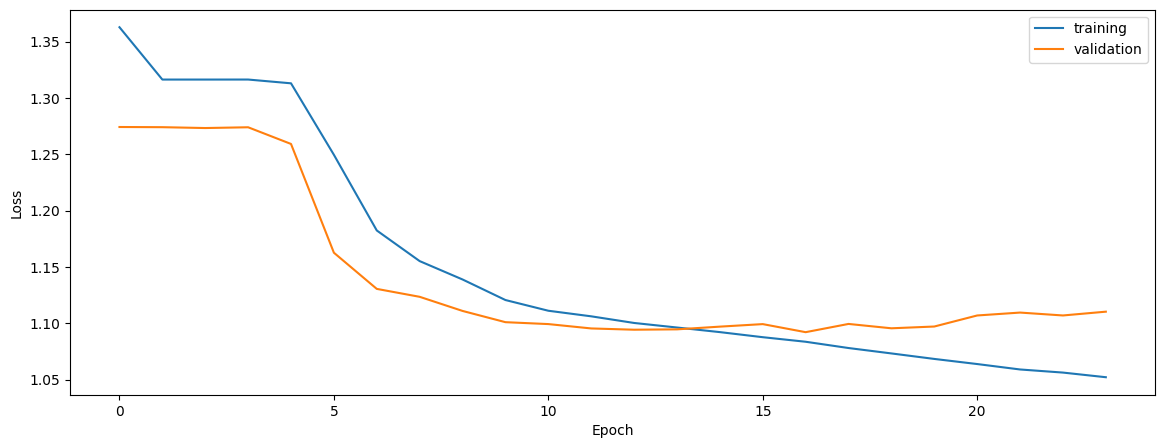

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


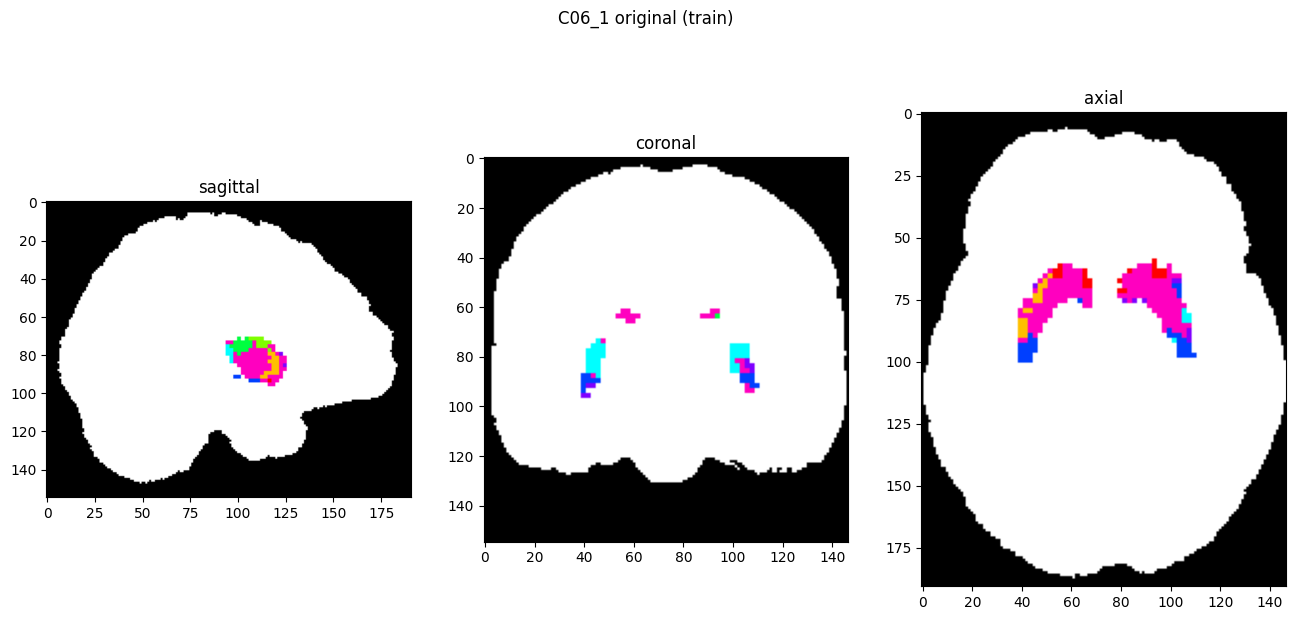

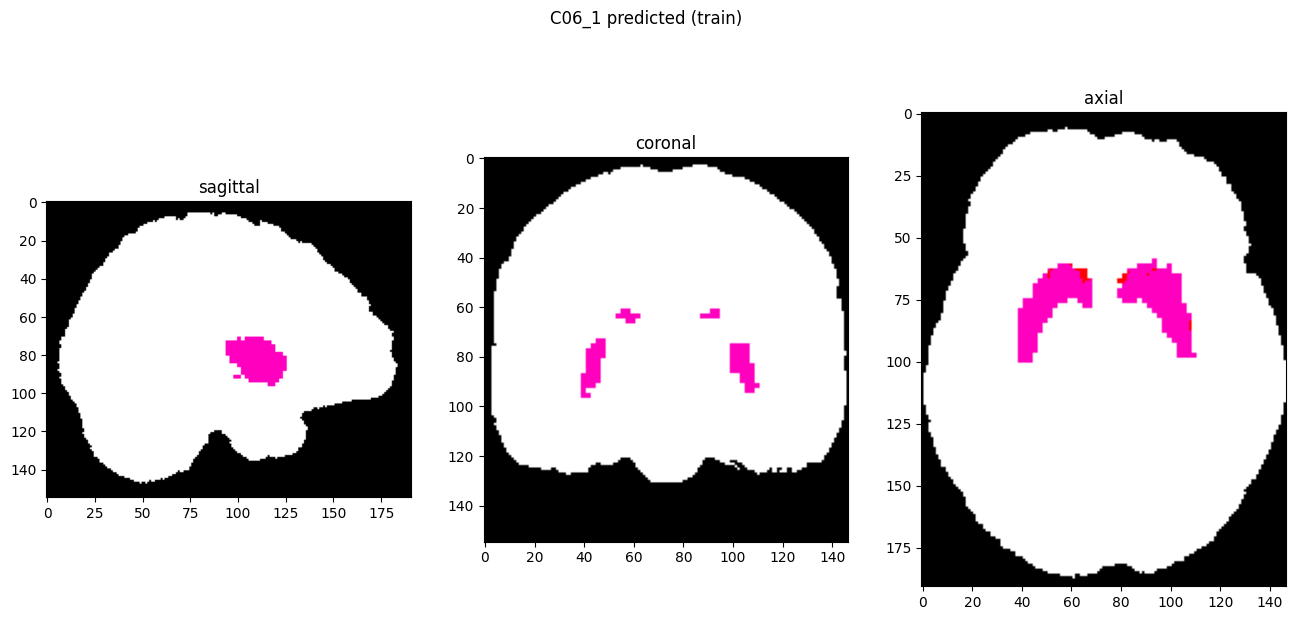

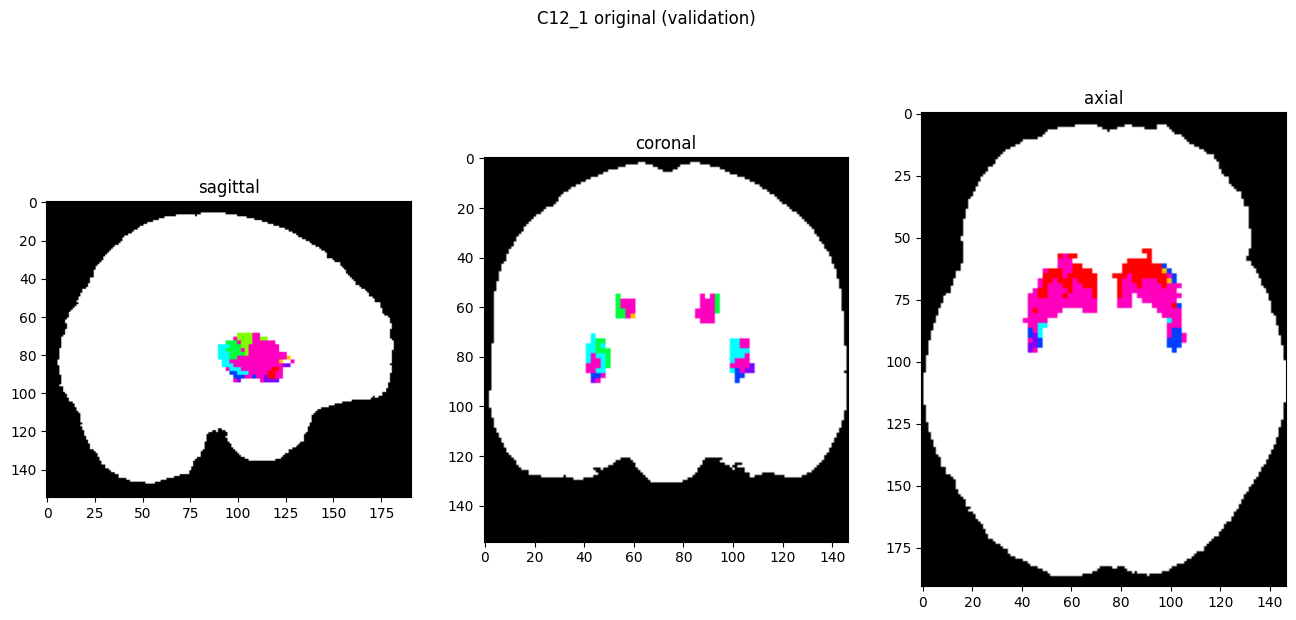

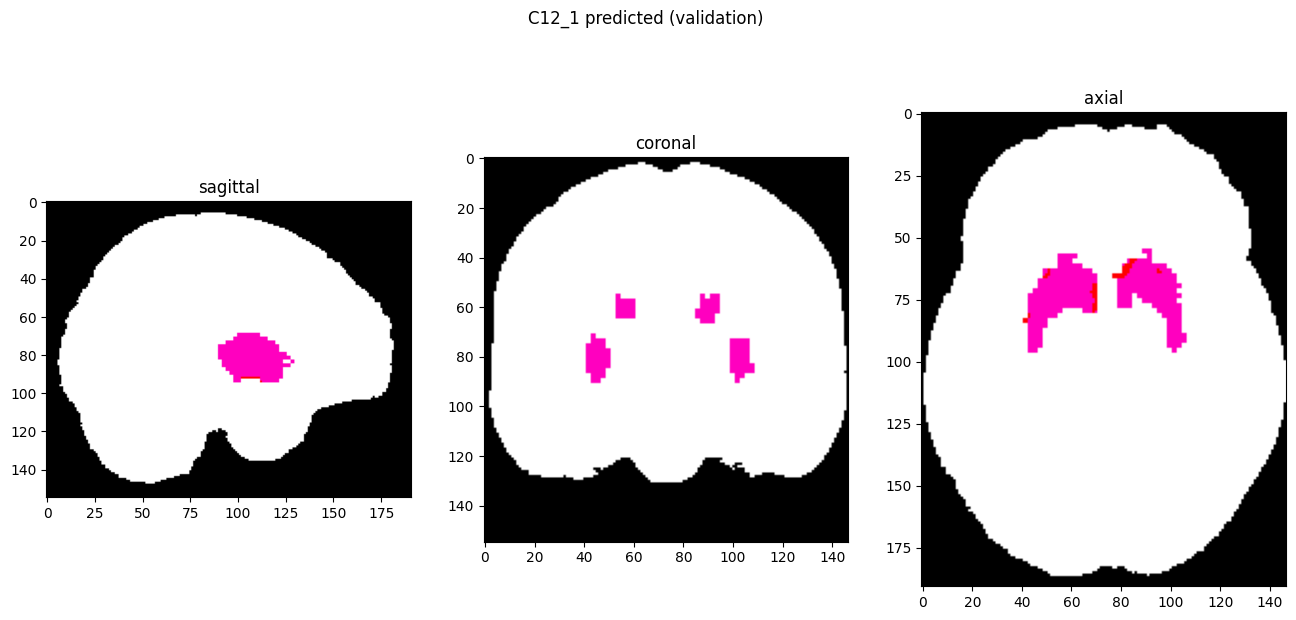

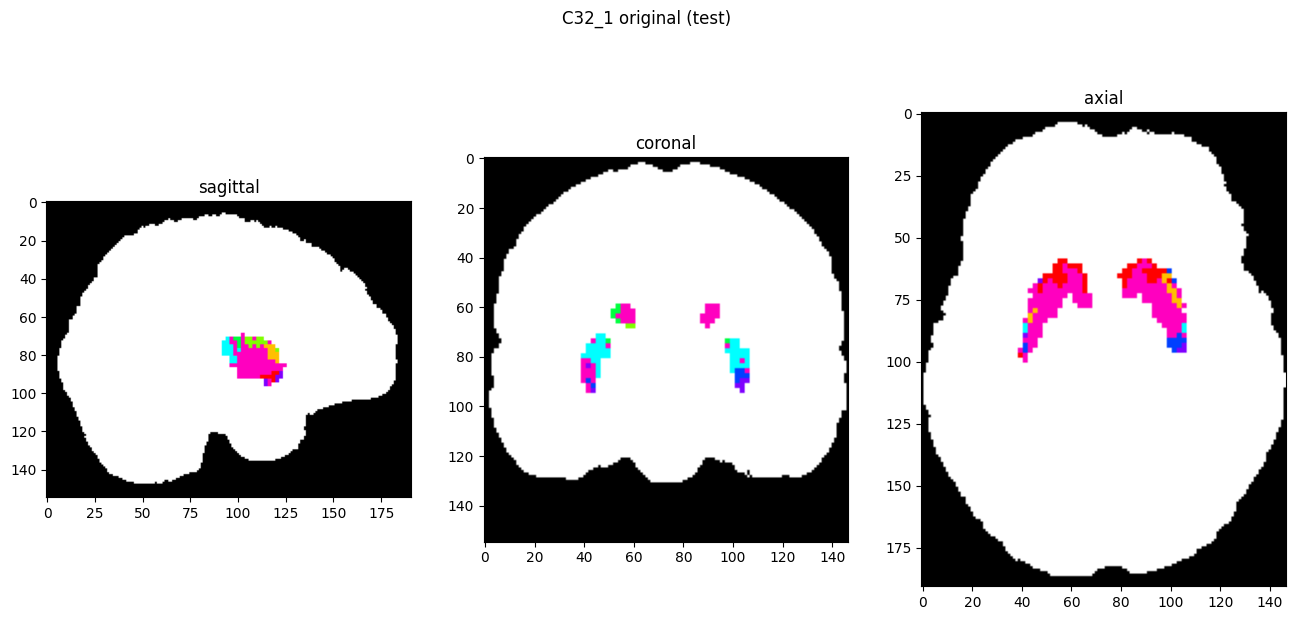

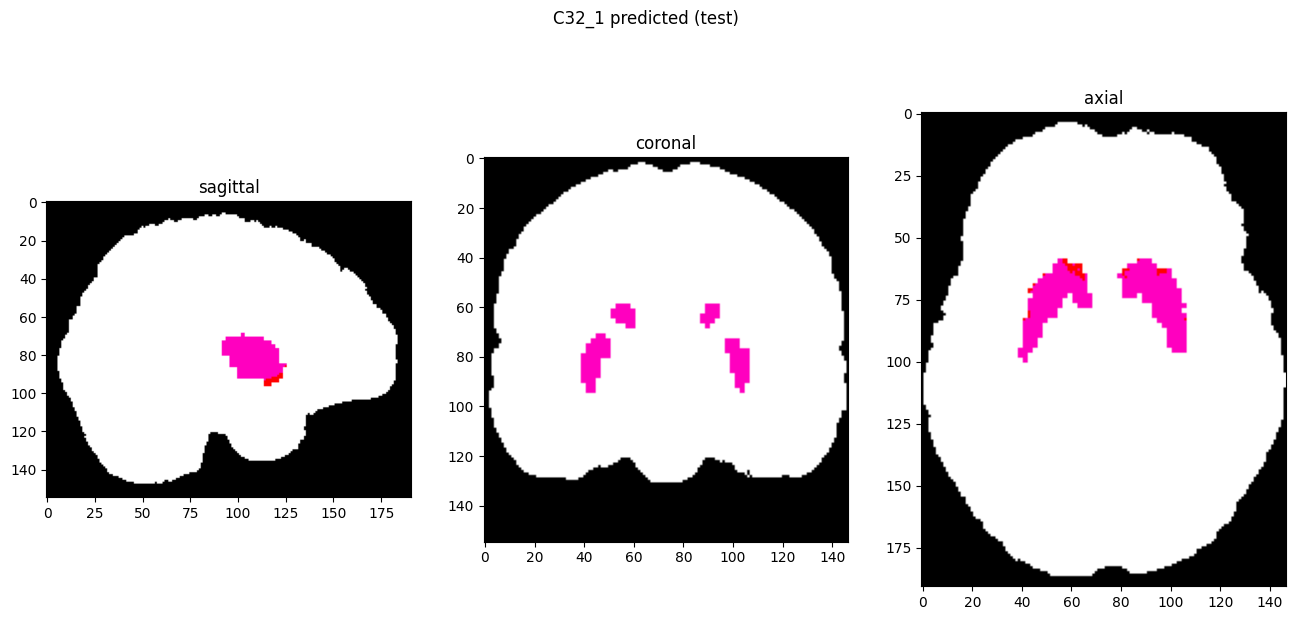

In [10]:
showResults(model, gen, threshold=0)